#Import Library

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 37.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [33]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Lipinski import NumHAcceptors,NumHDonors
from rdkit.Chem.Crippen import MolLogP

#Import Dataset

In [4]:
compounds= pd.read_csv("gdrive/MyDrive/PROJECT/KOMPUTASI/v2-Regression Anti Inflammatory/Dataset - Anti Inflammatory.csv", sep=";")

In [5]:
compounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          7430 non-null   object 
 1   Molecule Name               1700 non-null   object 
 2   Molecule Max Phase          7430 non-null   object 
 3   Molecular Weight            7430 non-null   object 
 4   #RO5 Violations             7430 non-null   object 
 5   AlogP                       7430 non-null   object 
 6   Compound Key                7430 non-null   object 
 7   Smiles                      7397 non-null   object 
 8   Standard Type               7430 non-null   object 
 9   Standard Relation           6430 non-null   object 
 10  Standard Value              6430 non-null   float64
 11  Standard Units              6449 non-null   object 
 12  pChEMBL Value               5149 non-null   float64
 13  Data Validity Comment       325 n

#Data Cleansing

##Drop Missing Value

In [6]:

compounds = compounds.dropna(subset=["Standard Value","Smiles"])
compounds = compounds[(compounds["Standard Value"]!=0) ]

##Drop Duplicates

In [7]:
compounds = compounds.drop_duplicates(subset=["Molecule ChEMBL ID"])

##Standard Unit

In [8]:
compounds = compounds[(compounds["Standard Relation"]=="'='")]

In [9]:
#Unit available
compounds['Standard Units'].unique()

array(['nM', '%', 'ug.mL-1', 'ug'], dtype=object)

In [10]:
#Take only mikro and nanomolar
#| (compounds["Standard Units"]=="µM")
compounds = compounds[(compounds["Standard Units"]=="nM") ].reset_index(drop=True)

##Convert Unit

In [11]:
IC50=[]

for i in range(len(compounds["Smiles"])):
  x= compounds["Standard Value"][i]
  if compounds["Standard Units"][i] != "nM":
    x = x*1000
  IC50.append(x)

In [12]:
x = {"Chembl ID":compounds["Molecule ChEMBL ID"],"Smiles":compounds["Smiles"],"IC50":IC50}
compounds = pd.DataFrame(data=x)
compounds = compounds[compounds["IC50"]>0].reset_index(drop=True)

In [13]:
compounds

,Chembl ID,Smiles,IC50
0,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,690.00
1,CHEMBL16516,CS(=O)(=O)c1ccc(-c2sc(CCCc3ccc(Br)cc3)nc2-c2cc...,7.00
2,CHEMBL126345,CS(=O)(=O)c1ccc(-c2[nH]c(SC#N)cc2-c2ccc(F)cc2)cc1,72000.00
3,CHEMBL98193,CN1CC(c2ccc(S(C)(=O)=O)cc2)=C(c2ccccc2)O1,5380.00
4,CHEMBL42180,Cc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc2...,109.65
...,...,...,...
3737,CHEMBL5082428,CCOC(=O)[C@H](OCc1cnnn1[C@@H](Cc1ccc(O)cc1)C(=...,700.00
3738,CHEMBL5080730,CCOC(=O)[C@H](O)[C@@H](OCc1cnnn1[C@@H](Cc1cccc...,32000.00
3739,CHEMBL121626,Cc1c(Cl)cccc1Nc1ccccc1C(=O)O,880.00
3740,CHEMBL4445481,NS(=O)(=O)c1ccc(-n2nc(C(=O)NCCCN3CCOCC3)cc2-c2...,170.00


#Change to pIC50

In [14]:
compounds["pIC50"]=-np.log10(compounds["IC50"])

compounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Chembl ID  3742 non-null   object 
 1   Smiles     3742 non-null   object 
 2   IC50       3742 non-null   float64
 3   pIC50      3742 non-null   float64
dtypes: float64(2), object(2)
memory usage: 117.1+ KB


#Lipinski Rule of Five Filter

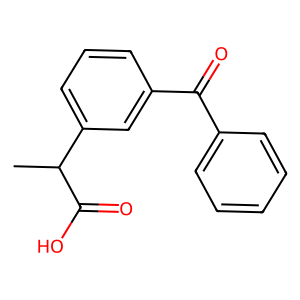

In [16]:
MolToImage(Chem.MolFromSmiles(compounds["Smiles"][0]))


In [17]:
compounds["MolWt"]=[MolWt(Chem.MolFromSmiles(x)) for x in compounds["Smiles"]]
compounds["nHA"]=[NumHAcceptors(Chem.MolFromSmiles(x)) for x in compounds["Smiles"]]
compounds["nHD"]=[NumHDonors(Chem.MolFromSmiles(x)) for x in compounds["Smiles"]]
compounds["MolLogP"]=[MolLogP(Chem.MolFromSmiles(x)) for x in compounds["Smiles"]]

In [18]:
compounds = compounds[(compounds["MolWt"]<500)&(compounds["MolLogP"]<5)&(compounds["nHA"]<10)&(compounds["nHD"]<5)]

In [19]:
compounds.describe()

,IC50,pIC50,MolWt,nHA,nHD,MolLogP
count,2.858000e+03,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000
mean,7.187657e+05,-2.964198,366.711677,4.643807,0.947166,3.449940
std,1.413837e+07,1.267338,60.937532,1.583671,0.899777,1.066457
min,5.998000e-03,-8.619790,108.144000,1.000000,0.000000,-4.509800
25%,1.200000e+02,-3.837114,330.319000,4.000000,0.000000,2.898800
50%,9.700000e+02,-2.986772,369.986000,5.000000,1.000000,3.665020
75%,6.872500e+03,-2.079181,410.421000,6.000000,1.000000,4.222355
max,4.166679e+08,2.221994,499.995000,9.000000,4.000000,4.998300


#Add Category

In [28]:
category=[]
for x in compounds["pIC50"]:
  if x <=-5.91:
    category.append("inactive")
  elif x <= -3.2:
    category.append("intermediate")
  elif x <= -0.49:
    category.append("active")
  else:
    category.append("potent")

category[0:5]

compounds["category"]=category


<ipython-input-28-a43a94094954>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds["category"]=category


In [29]:
compounds

,Chembl ID,Smiles,IC50,pIC50,MolWt,nHA,nHD,MolLogP,category
0,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,690.00,-2.838849,254.285,2,1,3.10570,active
2,CHEMBL126345,CS(=O)(=O)c1ccc(-c2[nH]c(SC#N)cc2-c2ccc(F)cc2)cc1,72000.00,-4.857332,372.446,4,1,4.46448,intermediate
3,CHEMBL98193,CN1CC(c2ccc(S(C)(=O)=O)cc2)=C(c2ccccc2)O1,5380.00,-3.730782,315.394,4,0,2.83540,intermediate
4,CHEMBL42180,Cc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc2...,109.65,-2.040009,398.381,4,0,4.40912,active
5,CHEMBL255175,NS(=O)(=O)c1ccc(/N=C/c2ccc([N+](=O)[O-])cc2)cc1,3000.00,-3.477121,305.315,5,1,1.99280,intermediate
...,...,...,...,...,...,...,...,...,...
3731,CHEMBL298031,COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(NS(C)(=O)=O)c...,960.00,-2.982271,411.405,5,1,3.93820,active
3733,CHEMBL93372,CC(=O)Oc1ccc(C2=C(c3ccc(S(C)(=O)=O)cc3)COC2=O)cc1,1.26,-0.100371,372.398,6,0,2.48300,potent
3734,CHEMBL1939671,Cc1c(CC(=O)OCCCO[N+](=O)[O-])cc(-c2ccc(S(C)(=O...,7.00,-0.845098,490.509,8,0,3.67942,active
3735,CHEMBL4641524,Fc1ccccc1-c1nnc(Cn2c(CN3CCCCC3)nc3ccccc32)o1,60.00,-1.778151,391.450,6,0,4.25960,active


In [31]:
compounds.to_csv("gdrive/MyDrive/PROJECT/KOMPUTASI/v2-Regression Anti Inflammatory/cleaned_dataset.csv",sep=";",index=False)

In [35]:
mols = [Chem.MolFromSmiles(x) for x in compounds["Smiles"]]
descrs = [Descriptors.CalcMolDescriptors(mol) for mol in mols]


In [37]:
pd.DataFrame(descrs).to_csv("gdrive/MyDrive/PROJECT/KOMPUTASI/v2-Regression Anti Inflammatory/rdkit_descriptor.csv",sep=";",index=False)